# Boston house price prediction with Vowpal Wabbit, LightGBM and Spark MLlib

This notebook shows how to build simple regression models by using 
[Vowpal Wabbit (VW)](https://github.com/VowpalWabbit/vowpal_wabbit) and 
[LightGBM](https://github.com/microsoft/LightGBM) with MMLSpark.
 We also compare the results with 
 [Spark MLlib Linear Regression](https://spark.apache.org/docs/latest/ml-classification-regression.html#linear-regression).

In [1]:
import math
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt
from mmlspark.train import ComputeModelStatistics
from mmlspark.vw import VowpalWabbitRegressor, VowpalWabbitFeaturizer
from mmlspark.lightgbm import LightGBMRegressor
import numpy as np
import pandas as pd
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from sklearn.datasets import load_boston

StatementMeta(SampleSpark2, 0, 1, Finished, Available)

## Prepare Dataset
We use [*Boston house price* dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html) 
. 
The data was collected in 1978 from Boston area and consists of 506 entries with 14 features including the value of homes. 
We use `sklearn.datasets` module to download it easily, then split the set into training and testing by 75/25.

In [2]:
boston = load_boston()

feature_cols = ['f' + str(i) for i in range(boston.data.shape[1])]
header = ['target'] + feature_cols
df = spark.createDataFrame(
    pd.DataFrame(data=np.column_stack((boston.target, boston.data)), columns=header)
).repartition(1)
print("Dataframe has {} rows".format(df.count()))
display(df.limit(10).toPandas())

StatementMeta(SampleSpark2, 0, 2, Finished, Available)

Dataframe has 506 rows


SynapseWidget(Synapse.DataFrame, b68511f3-8680-4657-bb82-13ab8780ce70)


/opt/spark/python/lib/pyspark.zip/pyspark/sql/session.py:714: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.enabled' is set to true; however, failed by the reason below:
  'JavaPackage' object is not callable
Attempting non-optimization as 'spark.sql.execution.arrow.fallback.enabled' is set to true.

In [3]:
train_data, test_data = df.randomSplit([0.75, 0.25], seed=42)
train_data.cache()
test_data.cache()

StatementMeta(SampleSpark2, 0, 3, Finished, Available)

DataFrame[target: double, f0: double, f1: double, f2: double, f3: double, f4: double, f5: double, f6: double, f7: double, f8: double, f9: double, f10: double, f11: double, f12: double]

Following is the summary of the training set.

In [4]:
display(train_data.summary().toPandas())

StatementMeta(SampleSpark2, 0, 4, Finished, Available)

SynapseWidget(Synapse.DataFrame, 1cf8ac80-99ec-48ce-8628-07f88576313c)

Plot feature distributions over different target values (house prices in our case).

In [5]:
features = train_data.columns[1:]
values = train_data.drop('target').toPandas()
ncols = 5
nrows = math.ceil(len(features) / ncols)

yy = [r['target'] for r in train_data.select('target').collect()]

f, axes = plt.subplots(nrows, ncols, sharey=True, figsize=(30,10))
f.tight_layout()

for irow in range(nrows):
    axes[irow][0].set_ylabel('target')
    for icol in range(ncols):
        try:
            feat = features[irow*ncols + icol]
            xx = values[feat]

            axes[irow][icol].scatter(xx, yy, s=10, alpha=0.25)
            axes[irow][icol].set_xlabel(feat)
            axes[irow][icol].get_yaxis().set_ticks([])
        except IndexError:
            f.delaxes(axes[irow][icol])

StatementMeta(SampleSpark2, 0, 5, Finished, Available)

Text(337.72222222222223, 0.5, 'target')
Text(0.5, 624.2516339869283, 'f0')
[]
Text(0.5, 624.2516339869283, 'f1')
[]
Text(0.5, 624.2516339869283, 'f2')
[]
Text(0.5, 624.2516339869283, 'f3')
[]
Text(0.5, 624.2516339869283, 'f4')
[]
Text(337.72222222222223, 0.5, 'target')
Text(0.5, 352.4869281045751, 'f5')
[]
Text(0.5, 352.4869281045751, 'f6')
[]
Text(0.5, 352.4869281045751, 'f7')
[]
Text(0.5, 352.4869281045751, 'f8')
[]
Text(0.5, 352.4869281045751, 'f9')
[]
Text(337.72222222222223, 0.5, 'target')
Text(0.5, 80.7222222222222, 'f10')
[]
Text(0.5, 80.7222222222222, 'f11')
[]
Text(0.5, 80.7222222222222, 'f12')
[]

## Baseline - Spark MLlib Linear Regressor

First, we set a baseline performance by using Linear Regressor in Spark MLlib.

In [6]:
featurizer = VectorAssembler(
    inputCols=feature_cols,
    outputCol='features'
)
lr_train_data = featurizer.transform(train_data)['target', 'features']
lr_test_data = featurizer.transform(test_data)['target', 'features']
display(lr_train_data.limit(10).toPandas())

StatementMeta(SampleSpark2, 0, 6, Finished, Available)

SynapseWidget(Synapse.DataFrame, 67ac460a-7e78-4921-a96a-8b67b49e9f78)


/opt/spark/python/lib/pyspark.zip/pyspark/sql/dataframe.py:2110: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.fallback.enabled' is set to true.
  warnings.warn(msg)
/opt/spark/python/lib/pyspark.zip/pyspark/sql/session.py:714: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.enabled' is set to true; however, failed by the reason below:
  Could not convert [38.3518,0.0,18.1,0.0,0.693,5.453,100.0,1.4896,24.0,666.0,20.2,396.9,30.59] with type DenseVector: did not recognize Python value type when inferring an Arrow data type
Attempting non-optimization as 'spark.sql.execution.arrow.fallback.enabled' is set to true.

In [7]:
# By default, `maxIter` is 100. Other params you may want to change include: `regParam`, `elasticNetParam`, etc.
lr = LinearRegression(
    labelCol='target',
)

lr_model = lr.fit(lr_train_data)
lr_predictions = lr_model.transform(lr_test_data)

display(lr_predictions.limit(10).toPandas())

StatementMeta(SampleSpark2, 0, 7, Finished, Available)

SynapseWidget(Synapse.DataFrame, 7bd61acb-f98f-4cbb-a96f-e48843fd5dbc)


/opt/spark/python/lib/pyspark.zip/pyspark/sql/session.py:714: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.enabled' is set to true; however, failed by the reason below:
  Could not convert [67.9208,0.0,18.1,0.0,0.693,5.683,100.0,1.4254,24.0,666.0,20.2,384.97,22.98] with type DenseVector: did not recognize Python value type when inferring an Arrow data type
Attempting non-optimization as 'spark.sql.execution.arrow.fallback.enabled' is set to true.

We evaluate the prediction result by using `mmlspark.train.ComputeModelStatistics` which returns four metrics:
* [MSE (Mean Squared Error)](https://en.wikipedia.org/wiki/Mean_squared_error)
* [RMSE (Root Mean Squared Error)](https://en.wikipedia.org/wiki/Root-mean-square_deviation) = sqrt(MSE)
* [R quared](https://en.wikipedia.org/wiki/Coefficient_of_determination)
* [MAE (Mean Absolute Error)](https://en.wikipedia.org/wiki/Mean_absolute_error)

In [8]:
metrics = ComputeModelStatistics(
    evaluationMetric='regression',
    labelCol='target',
    scoresCol='prediction'
).transform(lr_predictions)

results = metrics.toPandas()
results.insert(0, 'model', ['Spark MLlib - Linear Regression'])
display(results)

StatementMeta(SampleSpark2, 0, 8, Finished, Available)

SynapseWidget(Synapse.DataFrame, 4cb68db8-47ba-4599-af3c-3f250eb51c4e)

## Vowpal Wabbit

Perform VW-style feature hashing. Many types (numbers, string, bool, map of string to (number, string)) are supported.

In [9]:
vw_featurizer = VowpalWabbitFeaturizer(
    inputCols=feature_cols,
    outputCol='features',
)
vw_train_data = vw_featurizer.transform(train_data)['target', 'features']
vw_test_data = vw_featurizer.transform(test_data)['target', 'features']
display(vw_train_data.limit(10).toPandas())

StatementMeta(SampleSpark2, 0, 9, Finished, Available)

SynapseWidget(Synapse.DataFrame, 75b18f6a-0bd5-4c63-adb0-0e2d986848ad)


/opt/spark/python/lib/pyspark.zip/pyspark/sql/session.py:714: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.enabled' is set to true; however, failed by the reason below:
  Could not convert (1073741824,[287408178,419613213,464140333,556319843,584064458,780495775,824677867,851899283,921728202,933181289,1055634727],[20.2,100.0,18.1,1.4896,666.0,24.0,30.59,5.453,396.9,38.3518,0.693]) with type SparseVector: did not recognize Python value type when inferring an Arrow data type
Attempting non-optimization as 'spark.sql.execution.arrow.fallback.enabled' is set to true.

See [VW wiki](https://github.com/vowpalWabbit/vowpal_wabbit/wiki/Command-Line-Arguments) for command line arguments.

In [10]:
# Use the same number of iterations as Spark MLlib's Linear Regression (=100)
args = "--holdout_off --loss_function quantile -l 7 -q :: --power_t 0.3"
vwr = VowpalWabbitRegressor(
    labelCol='target',
    args=args,
    numPasses=100,
)

# To reduce number of partitions (which will effect performance), use `vw_train_data.repartition(1)`
vw_train_data_2 = vw_train_data.repartition(1).cache()
print(vw_train_data_2.count())
vw_model = vwr.fit(vw_train_data_2.repartition(1))
vw_predictions = vw_model.transform(vw_test_data)

display(vw_predictions.limit(10).toPandas())

StatementMeta(SampleSpark2, 0, 10, Finished, Available)

377


SynapseWidget(Synapse.DataFrame, f093dd5e-769b-4894-b2d0-08ef38edeb67)


/opt/spark/python/lib/pyspark.zip/pyspark/sql/session.py:714: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.enabled' is set to true; however, failed by the reason below:
  Could not convert (1073741824,[287408178,419613213,464140333,556319843,584064458,780495775,824677867,851899283,921728202,933181289,1055634727],[20.2,100.0,18.1,1.4254,666.0,24.0,22.98,5.683,384.97,67.9208,0.693]) with type SparseVector: did not recognize Python value type when inferring an Arrow data type
Attempting non-optimization as 'spark.sql.execution.arrow.fallback.enabled' is set to true.

In [11]:
metrics = ComputeModelStatistics(
    evaluationMetric='regression',
    labelCol='target',
    scoresCol='prediction'
).transform(vw_predictions)

vw_result = metrics.toPandas()
vw_result.insert(0, 'model', ['Vowpal Wabbit'])
results = results.append(
    vw_result,
    ignore_index=True
)
display(results)

StatementMeta(SampleSpark2, 0, 11, Finished, Available)

SynapseWidget(Synapse.DataFrame, 101b367b-fea5-40ed-a21d-9e329f7c6733)

## LightGBM

In [12]:
lgr = LightGBMRegressor(
    objective='quantile',
    alpha=0.2,
    learningRate=0.3,
    numLeaves=31,
    labelCol='target',
    numIterations=100,
)

# Using one partition since the training dataset is very small
repartitioned_data = lr_train_data.repartition(1).cache()
print(repartitioned_data.count())
lg_model = lgr.fit(repartitioned_data)
lg_predictions = lg_model.transform(lr_test_data)

display(lg_predictions.limit(10).toPandas())

StatementMeta(SampleSpark2, 0, 12, Finished, Available)

377


SynapseWidget(Synapse.DataFrame, d5510992-334f-4923-8431-4b7cd4d2fd26)

In [13]:
metrics = ComputeModelStatistics(
    evaluationMetric='regression',
    labelCol='target',
    scoresCol='prediction'
).transform(lg_predictions)

lg_result = metrics.toPandas()
lg_result.insert(0, 'model', ['LightGBM'])
results = results.append(
    lg_result,
    ignore_index=True
)
display(results)

StatementMeta(SampleSpark2, 0, 13, Finished, Available)

SynapseWidget(Synapse.DataFrame, f392ffbc-b63e-4173-bf67-0a565b734571)

Following figure shows the actual-vs.-prediction graphs of the results:

<img width="1102" alt="lr-vw-lg" src="https://user-images.githubusercontent.com/42475935/64071975-4c3e9600-cc54-11e9-8b1f-9a1ee300f445.png">

In [14]:
cmap = get_cmap('YlOrRd')

target = np.array(test_data.select('target').collect()).flatten()
model_preds = [
    ("Spark MLlib Linear Regression", lr_predictions),
    ("Vowpal Wabbit", vw_predictions),
    ("LightGBM", lg_predictions)
]

StatementMeta(SampleSpark2, 0, 14, Finished, Available)

StatementMeta(SampleSpark2, 0, 15, Finished, Available)

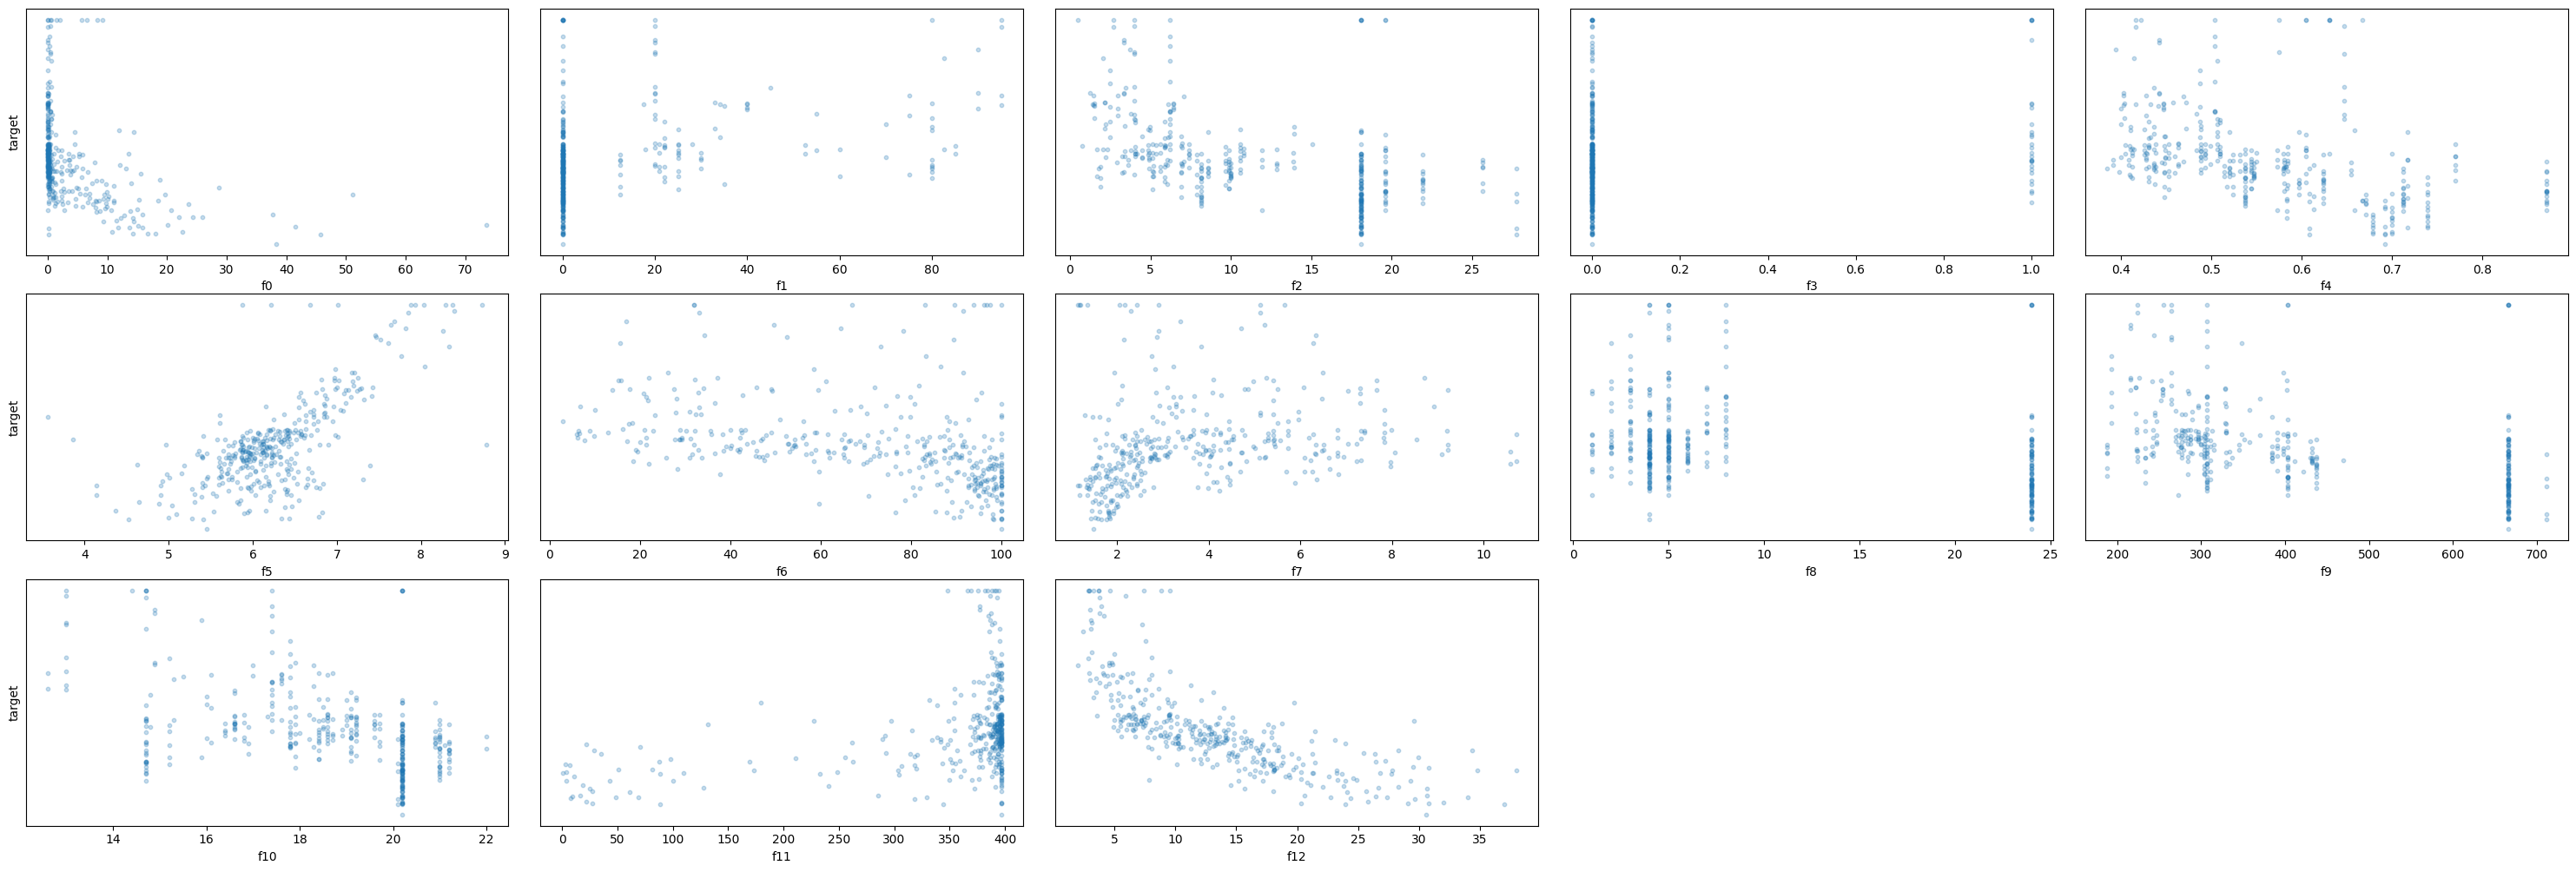

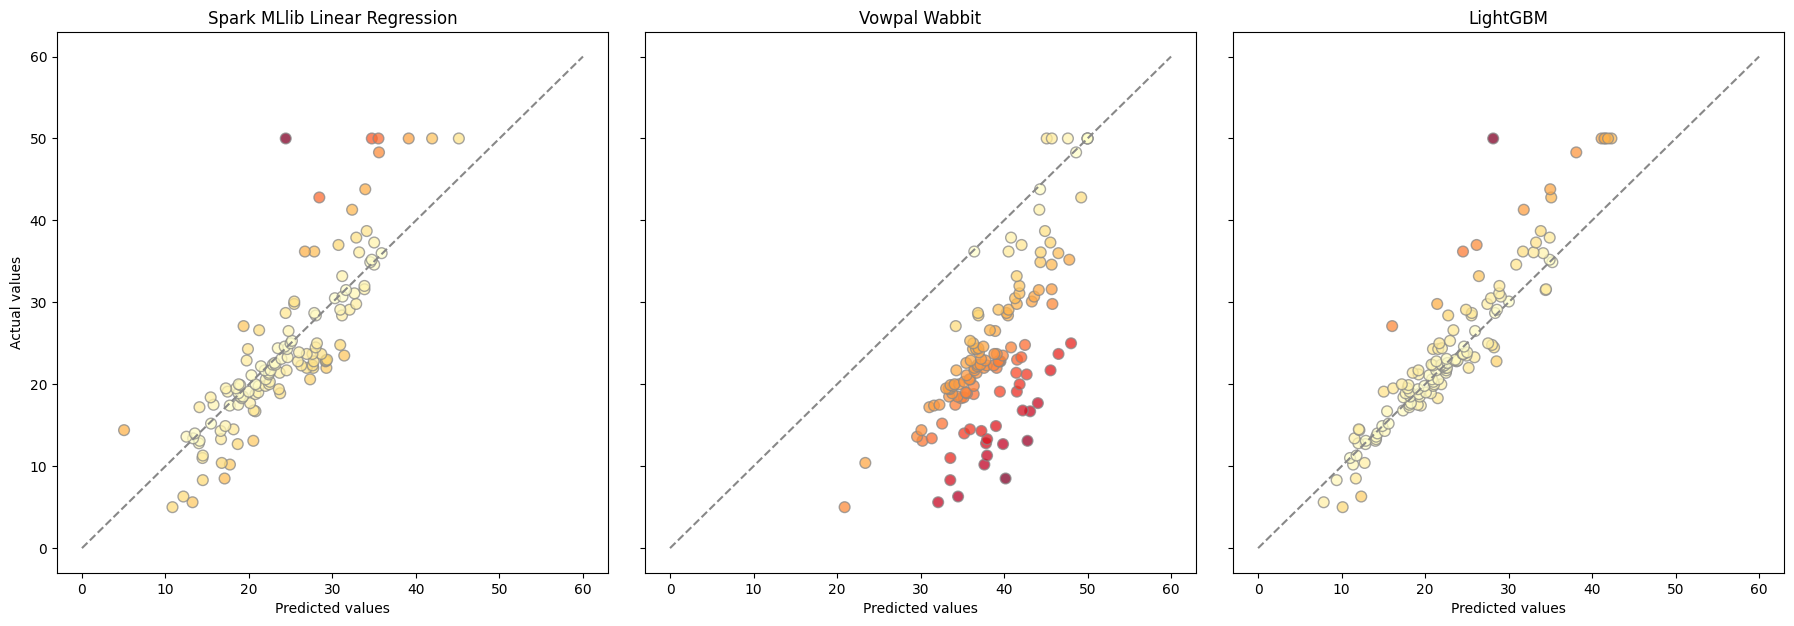

In [15]:
f, axes = plt.subplots(1, len(model_preds), sharey=True, figsize=(18, 6))
f.tight_layout()

for i, (model_name, preds) in enumerate(model_preds):
    preds = np.array(preds.select('prediction').collect()).flatten()
    err = np.absolute(preds - target)

    norm = Normalize()
    clrs = cmap(np.asarray(norm(err)))[:, :-1]
    axes[i].scatter(preds, target, s=60, c=clrs, edgecolors='#888888', alpha=0.75)
    axes[i].plot((0, 60), (0, 60), linestyle='--', color='#888888')
    axes[i].set_xlabel('Predicted values')
    if i ==0:
        axes[i].set_ylabel('Actual values')
    axes[i].set_title(model_name)
plt.show()

## Clean up resources
To ensure the Spark instance is shut down, end any connected sessions(notebooks). The pool shuts down when the **idle time** specified in the Apache Spark pool is reached. You can also select **stop session** from the status bar at the upper right of the notebook.

![stopsession](https://adsnotebookrelease.blob.core.windows.net/adsnotebookrelease/adsnotebook/image/stopsession.png)

## Next steps

* [Check out Synapse sample notebooks](https://github.com/Azure-Samples/Synapse/tree/main/MachineLearning) 
* [MMLSpark GitHub Repo](https://github.com/Azure/mmlspark)